<a href="https://colab.research.google.com/github/saylejl24/ImagePlay/blob/main/DepthImgGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating A Depth Image using Disparity of 2 images

In [ ]:
D=3 #patch size 

Read in the image data

In [ ]:
import cv2
import numpy as np
imleft = (cv2.imread("sample_data/conesLeft.ppm"))/255
imleft = imleft.astype(np.float32)
imright = (cv2.imread("sample_data/conesRight.ppm"))/255
imright = imright.astype(np.float32)

Convert to Gray scale image 

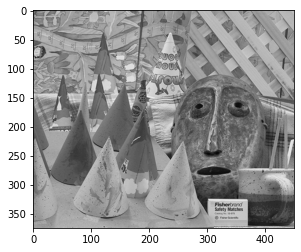

In [ ]:
imleftgrey = cv2.cvtColor(imleft, cv2.COLOR_BGR2GRAY)
imrightgrey = cv2.cvtColor(imright, cv2.COLOR_BGR2GRAY)
import matplotlib.pyplot as plt


plt.imshow(imleftgrey, plt.cm.gray)

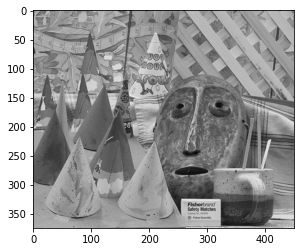

In [ ]:
plt.imshow(imrightgrey, plt.cm.gray)

In [ ]:
[nrows, ncols] = imleftgrey.shape
imleftgrey.shape

(375, 450)

Generate the Black Depth Image

In [ ]:
image_depth = np.zeros((nrows,ncols), np.float32)
image_depth.shape

(375, 450)

Add D Padding

In [ ]:
new_imleftgrey = np.zeros((nrows+2*D, ncols+2*D), np.float32)
new_imrightgrey = np.zeros((nrows+2*D, ncols+2*D), np.float32)
new_imleftgrey.shape

(381, 456)

In [ ]:
new_imleftgrey[D:D+nrows,D:D+ncols] = imleftgrey
#new_imleftgrey[D+1:D+nrows,D+1:D+ncols+1] = imleftgrey
new_imrightgrey[D:D+nrows,D:D+ncols] = imrightgrey
#new_imrightgrey[D+1:D+nrows,D+1:D+ncols+1] = imrightgrey
new_imleftgrey.shape

(381, 456)

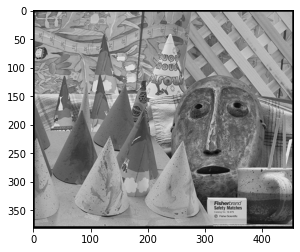

In [ ]:
plt.figure()
plt.imshow(new_imleftgrey, plt.cm.gray) # display im with padding 

In [ ]:
import numpy as np

def im2col_sliding(image, block_size, skip=1):

    rows, cols = image.shape
    horz_blocks = cols - block_size[1] + 1
    vert_blocks = rows - block_size[0] + 1

    output_vectors = np.zeros((block_size[0] * block_size[1], horz_blocks * vert_blocks))
    itr = 0
    for v_b in range(vert_blocks):
        for h_b in range(horz_blocks):
            output_vectors[:, itr] = image[v_b: v_b + block_size[0], h_b: h_b + block_size[1]].ravel()
            itr += 1

    return output_vectors[:, ::skip]

In [ ]:
def normalize_matrix_col(matrix):
  rows, cols = matrix.shape

  n_m = np.zeros((rows, cols))
  mean_m =  matrix.mean()

 # print(mean_m)

  var_m = np.zeros((1, cols))

  for i in range(1, cols):
    n_m[:,i] = matrix[:,i]-mean_m

 # print(n_m)

  for i in range(1, cols):
    var_m[:, i] = np.dot(np.transpose(n_m[:,i]), n_m[:,i])
    var_m[:, i] =  np.sqrt(var_m[:,i])
  
 # print(var_m)
  
  for i in range(1, cols):
    n_m[:,i] = np.divide(n_m[:,i], var_m[:,i])

  return n_m

In [ ]:
print(ncols)

450


In [ ]:
print(np.arange(16).reshape(4,4))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [ ]:
print(im2col_sliding(np.arange(16).reshape(4,4), (2,2)))
x = im2col_sliding(np.arange(16).reshape(4,4), (2,2))
print(x)

[[ 0.  1.  2.  4.  5.  6.  8.  9. 10.]
 [ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 4.  5.  6.  8.  9. 10. 12. 13. 14.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]]
[[ 0.  1.  2.  4.  5.  6.  8.  9. 10.]
 [ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 4.  5.  6.  8.  9. 10. 12. 13. 14.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]]


In [ ]:
for ii in range(nrows):
  # on each iteration process one row and generate one DSI
  i = ii + D
  print("Start one row {}".format(ii))
 
  # NCC
  DSI_image = np.zeros((ncols, ncols), np.float32); 
 
  # generate a patch for NCC operation 
  #big_patch = new_imleftgrey[i-D:i+D + 1, 0:ncols+2*D]
  big_patch = new_imleftgrey[i-D:i+D, 1:ncols+2*D]

  #print("the big patch is :" , big_patch.shape)
  kernel = np.zeros((2*D+1,2*D+1), np.float32)
  f_matrix = im2col_sliding(big_patch, (2 * D, 2 * D))
  
  # Normalize f matrix
  #print(f_matrix.shape)
  #f_matrix_N = f_matrix / f_matrix.max(axis=0)
  f_matrix_N = normalize_matrix_col(f_matrix)
  
  #Repeat for right 
  #big_patch = new_imrightgrey[i-D:i+D + 1, 0:ncols+2*D]
  big_patch = new_imrightgrey[i-D:i+D, 1:ncols+2*D]
  g_matrix=im2col_sliding(big_patch, (2 * D, 2 * D))
  #print(g_matrix.shape)

  #NCC operation get 1-NCC
  #g_matrix_N = g_matrix / g_matrix.max(axis=0)
  g_matrix_N = normalize_matrix_col(g_matrix)
  DSI_image = 1 - np.dot(np.transpose(g_matrix_N), f_matrix_N)
  print("finish NCC") 

  # Dynamic Program 
  dynimic_graph=np.zeros([ncols,ncols])
  directmap = np.zeros([ncols, ncols])
  pathmap = np.zeros([ncols, ncols])
  conclusion = 0.7

  # init the upper edge and left edge
  for pt in range(2, ncols):
    dynimic_graph[pt,1]=dynimic_graph[pt-1,1]+conclusion;directmap[pt,1]=2;
    dynimic_graph[1,pt]=dynimic_graph[1,pt-1]+conclusion;directmap[1,pt]=3;

  # Dynamic prog step 1 
  for pti in range(2, ncols):
    for ptj in range(2, ncols):
      min1=dynimic_graph[pti-1,ptj-1]+DSI_image[pti,ptj];  # diagnals path
      #print("min1:" + str(min1))
      min2=dynimic_graph[pti-1,ptj]+conclusion;      # vertical path
      #print("min2:" + str(min2))
      min3=dynimic_graph[pti,ptj-1]+conclusion;      # horizotal path
      dynimic_graph[pti,ptj]=min([min1,min2,min3]);
      if(min([min1,min2,min3]) == min1):
        directmap[pti,ptj]=1;
        #print("option 1")
        #print(str(directmap[pti, ptj]))
      elif(min([min1,min2,min3]) == min2):
        directmap[pti,ptj]=2;
        #print("option 2")
        #print(str(directmap[pti, ptj]))
      elif(min([min1,min2,min3]) == min3):
      #else:
        #print("option 3")
        directmap[pti,ptj]=3;
        #print(str(directmap[pti, ptj]))
  # dynamic prog step 2 
  #p=ncols -2;
  p=ncols -1;
  #q=ncols -2;
  q=ncols -1; 
  while (p>1 or q>1):
    pathmap[p,q]=1
    if(directmap[p,q] == np.float32(1)):
      p = p-1
      q = q-1
      image_depth[ii, q] = abs(q-p)
    if(directmap[p,q] == np.float32(2)):
      p = p-1
    if(directmap[p,q] == np.float32(3)):
    #else:
      q = q-1
      image_depth[ii, q] = abs(q-p)
  
  # normalize pixels value 0-1 to display in matlab 
  #image_depth = image_depth / image_depth.max(axis=0)
  #image_depth1 = (np.float32(image_depth) - image_depth.min()) / (image_depth.max()- image_depth.min())
  #plt.imshow(image_depth1, plt.cm.gray)

ma = np.max(np.max(image_depth))
image_depth = np.divide(image_depth, ma)

Start one row 0
finish NCC
Start one row 1
finish NCC
Start one row 2
finish NCC
Start one row 3
finish NCC
Start one row 4
finish NCC
Start one row 5
finish NCC
Start one row 6
finish NCC
Start one row 7
finish NCC
Start one row 8
finish NCC
Start one row 9
finish NCC
Start one row 10
finish NCC
Start one row 11
finish NCC
Start one row 12
finish NCC
Start one row 13
finish NCC
Start one row 14
finish NCC
Start one row 15
finish NCC
Start one row 16
finish NCC
Start one row 17
finish NCC
Start one row 18
finish NCC
Start one row 19
finish NCC
Start one row 20
finish NCC
Start one row 21
finish NCC
Start one row 22
finish NCC
Start one row 23
finish NCC
Start one row 24
finish NCC
Start one row 25
finish NCC
Start one row 26
finish NCC
Start one row 27
finish NCC
Start one row 28
finish NCC
Start one row 29
finish NCC
Start one row 30
finish NCC
Start one row 31
finish NCC
Start one row 32
finish NCC
Start one row 33
finish NCC
Start one row 34
finish NCC
Start one row 35
finish NCC
St

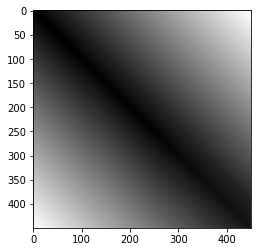

In [ ]:
image_depth2 = (image_depth - np.min(image_depth))/np.ptp(image_depth)
plt.imshow(image_depth, plt.cm.gray)
plt.imshow(dynimic_graph, plt.cm.gray)

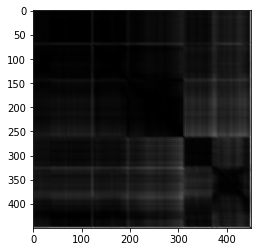

In [ ]:
plt.imshow(DSI_image, plt.cm.gray)

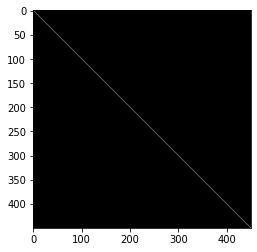

In [ ]:
plt.imshow(pathmap, plt.cm.gray)

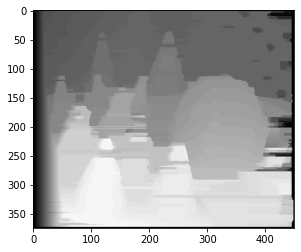

In [ ]:
#image3 = np.true_divide(image_depth, 255, dtype=np.float32)
plt.imshow(image_depth, plt.cm.gray)